In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./archive/realtor-data.zip.csv")
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


## Exploratory Data Analasis (EDA)

In [3]:
print(f"Numerical variables in dataset: {df.select_dtypes(exclude = ['object']).columns.tolist()}")
print(f"Categorical variables in dataset: {df.select_dtypes(include = ['object']).columns.tolist()}")

Numerical variables in dataset: ['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'price']
Categorical variables in dataset: ['status', 'city', 'state', 'prev_sold_date']


In [4]:
df.status.unique()

array(['for_sale', 'ready_to_build'], dtype=object)

In [5]:
df.city.unique()

array(['Adjuntas', 'Juana Diaz', 'Ponce', ..., 'Peekskill', 'Armonk',
       'North Salem'], dtype=object)

In [6]:
df.isna().sum()

status                 0
bed               129840
bath              113884
acre_lot          266642
city                  72
state                  0
zip_code             204
house_size        292886
prev_sold_date    459101
price                 71
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bed,775126.0,3.332190,2.065312e+00,1.0,2.00,3.00,4.00,123.0
bath,791082.0,2.484236,1.931622e+00,1.0,2.00,2.00,3.00,198.0
acre_lot,638324.0,17.317292,9.707074e+02,0.0,0.11,0.29,1.15,100000.0
zip_code,904762.0,6519.464582,3.816713e+03,601.0,2908.00,6811.00,8854.00,99999.0
house_size,612080.0,2138.436667,3.046600e+03,100.0,1132.00,1650.00,2495.00,1450112.0
price,904895.0,877438.158334,2.457698e+06,0.0,268500.00,475000.00,830000.00,875000000.0


In [8]:
df.dropna(subset = 'price', inplace=True)

In [9]:
df.shape

(904895, 10)

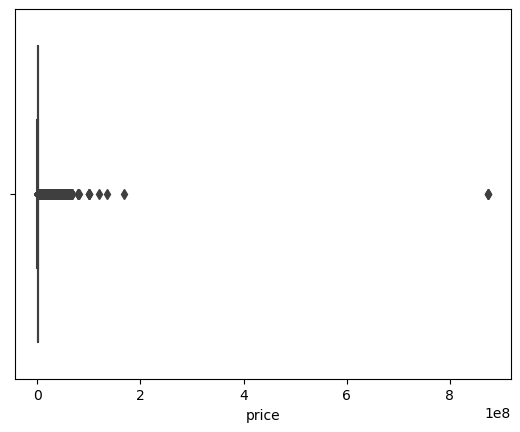

In [10]:
sns.boxplot(df,x='price')
plt.show()

It is difficult to see the actual distribution of the target variable due to the outliers. We will remove those outliers and create the box plot again.

To remove the outlier for better visualization, we will remove the top 10% of high prices.

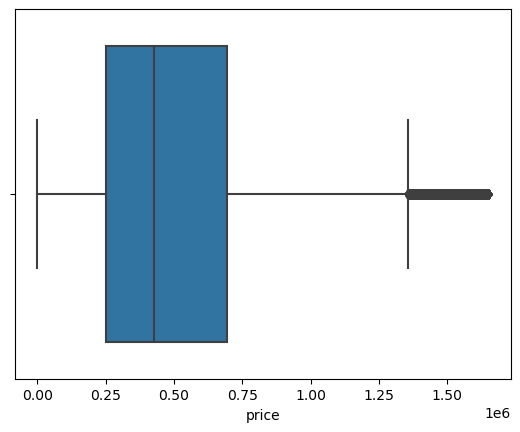

In [11]:
outlier_cutoff = df.price.quantile(0.9)
sns.boxplot(df[df['price']<outlier_cutoff], x = 'price')
plt.show()

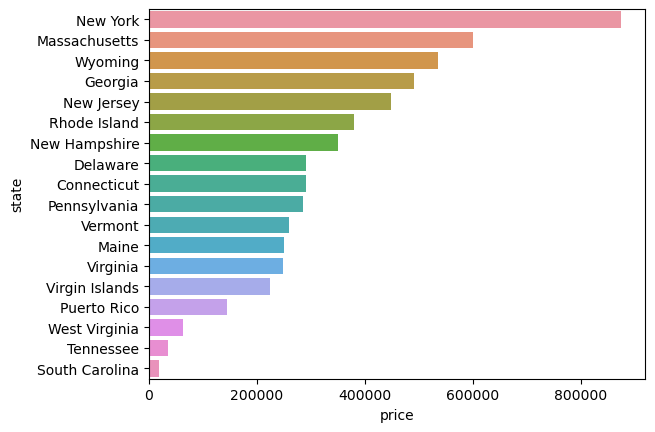

In [12]:
df_data = df.groupby('state', as_index=False)['price'].median().sort_values('price', ascending=False)
sns.barplot(data = df_data, x = 'price', y = 'state')
plt.show()

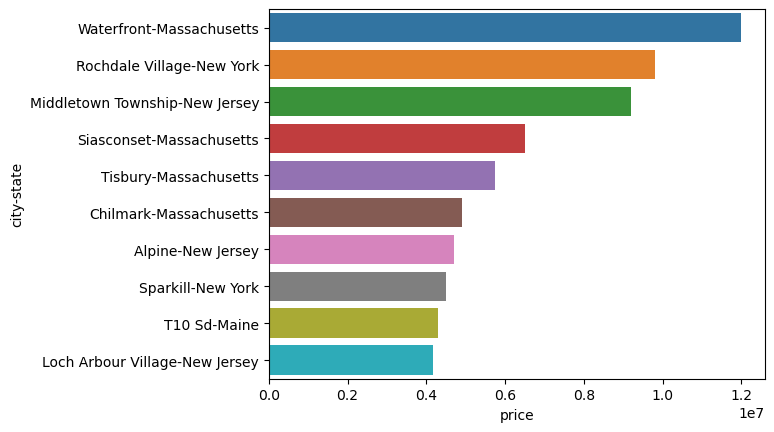

In [13]:
df_data = df.groupby(['city', 'state'], as_index=False)['price'].median().sort_values('price', ascending=False).head(10)
df_data['city-state'] = df_data['city'] + '-' +df_data['state'] 
sns.barplot(data = df_data, x = 'price', y = 'city-state')
plt.show()

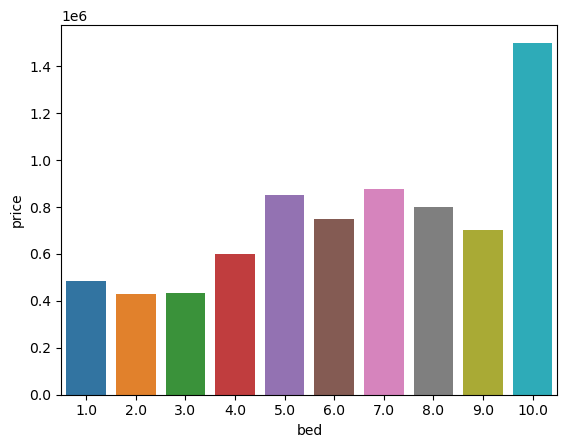

In [14]:
# to visualize how the num of bedroom could affect on the home price,
# we will combine the samples with 10 or above bedrooms together, 
# since we only have limited amount of samples like that in the dataset
df_data = df.copy()
df_data.loc[df_data['bed']>=10, 'bed'] = 10
df_price_bed = df_data.groupby('bed', as_index=False)['price'].median()
sns.barplot(df_price_bed, x = 'bed', y = 'price')
plt.show()

In [15]:
df.isnull().sum()

status                 0
bed               129840
bath              113813
acre_lot          266571
city                  72
state                  0
zip_code             204
house_size        292886
prev_sold_date    459030
price                  0
dtype: int64

## Cleaning

In [16]:
def remove_with_all_missings(df):
    """
    Remove the records when missing important features,
    here the important features are house size, bedroom, bathroom, and acre lot
    """
    df = df[(~df['house_size'].isnull()) | (~df['bed'].isnull())
           | (~df['bath'].isnull()) | (~df['acre_lot'].isnull())]
    
    return df

In [17]:
df_clean = remove_with_all_missings(df)

C:\Users\hp\AppData\Local\Temp\ipykernel_23360\1970912677.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mx = df_clean.corr()


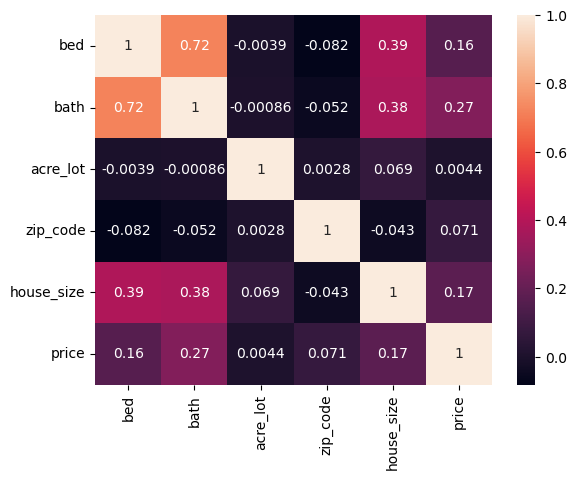

In [18]:
corr_mx = df_clean.corr()
sns.heatmap(corr_mx,annot=True)
plt.show()

See from the above correlation matrix, bedrooms and bathrooms counts are highly correlated. So we can use one to help fill missing values for another. Also, for the rest missing values, we can fill with the most frequently appeared values for the zip code, since we normally see similar house structure or size within the same neighborhood.

Here are some thoughts about filling the missing values for bedroom and bathroom columns:

1. We can find out the median values for bedroom / bathroom counts using bathroom/bedroom or zip code as group
2. Fill the missing values for bedroom or bathroom with median values

In [19]:
def filling_bed_bath(df):
    
     # first, obtain the most frequent bedroom counts using bathroom or zip code as group
    # similarity find the most frequent bathroom counts using bedroom or zip code as group
    
    df_mode_bed_per_bath = df.groupby(['bath'], as_index=False)['bed'].median().rename(columns = {'bed':'fill_bed_with_bath'})
    df_bed_per_zip = df.groupby('zip_code', as_index=False)['bed'].median().rename(columns = {'bed':'fill_bed_with_zip'})
    df_mode_bath_per_bath = df.groupby(['bed'], as_index=False)['bath'].median().rename(columns = {'bath':'fill_bath_with_bed'})
    df_bath_per_zip = df.groupby('zip_code', as_index=False)['bath'].median().rename(columns = {'bath':'fill_bath_with_zip'})

    df = df.merge(df_mode_bed_per_bath, on = ['bath'], how='left').merge(df_bed_per_zip, on = ['zip_code'], how='left')\
    .merge(df_mode_bath_per_bath, on = ['bed'], how='left').merge(df_bath_per_zip, on = ['zip_code'], how='left')

    # fill missing values for bedroom column with bathroom info
    df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_bath'].isnull()), 'bed'] = df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_bath'].isnull()), 'fill_bed_with_bath']
    
    # fill missing values for bathroom column with bedroom info
    df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_bed'].isnull()), 'bath'] = df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_bed'].isnull()), 'fill_bath_with_bed']

    # for the remaining, see if we can fill with zip code info
    df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_zip'].isnull()), 'bed'] = df.loc[(df['bed'].isnull()) & (~df['fill_bed_with_zip'].isnull()), 'fill_bed_with_zip']
    df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_zip'].isnull()), 'bath'] = df.loc[(df['bath'].isnull()) & (~df['fill_bath_with_zip'].isnull()), 'fill_bath_with_zip']

    df.drop(['fill_bed_with_bath','fill_bed_with_zip', 'fill_bath_with_bed', 'fill_bath_with_zip'], axis = 1, inplace=True)
    return df

In [20]:
df_clean = filling_bed_bath(df_clean)

#### Fill missing values for house size and acre lot

- From the correlation matrix, we see the house size is correlated with bedroom and bathrooms counts. We will fill the house size based on those two features along with zip code.

- In general, within the same neighborhood, the lot size are similar from each property. Here, we will use that assumption and fill the missing values for acre_lot column using zip code info.

In [21]:
def filling_house_size_lot(df):
    # first, obtain the median house size using bathroom bedroom counts as group
    # similarity find the median house size using zip code as group
    # find the median appeared lot size using zip code as group
    df_mode_house_size = df.groupby(['bath', 'bed'], as_index=False)['house_size'].median().rename(columns = {'house_size':'filled_house_size'})
    df_house_size_per_zip = df.groupby('zip_code', as_index=False)['house_size'].median().rename(columns = {'house_size':'fill_house_size_with_zip'})
    df_lot_per_zip = df.groupby('zip_code', as_index=False)['acre_lot'].median().rename(columns = {'acre_lot':'fill_acre_lot_with_zip'})

    df = df.merge(df_mode_house_size, on = ['bath', 'bed'], how='left').merge(df_house_size_per_zip, on = ['zip_code'], how='left')\
    .merge(df_lot_per_zip, on = ['zip_code'], how='left')

    # fill missing values for house size
    df.loc[(df['house_size'].isnull()) & (~df['filled_house_size'].isnull()), 'house_size'] = df.loc[(df['house_size'].isnull()) & (~df['filled_house_size'].isnull()), 'filled_house_size']
    df.loc[(df['house_size'].isnull()) & (~df['fill_house_size_with_zip'].isnull()), 'house_size'] = df.loc[(df['house_size'].isnull()) & (~df['fill_house_size_with_zip'].isnull()), 'fill_house_size_with_zip']

    # fill missing values for lot size
    df.loc[(df['acre_lot'].isnull()) & (~df['fill_acre_lot_with_zip'].isnull()), 'acre_lot'] = df.loc[(df['acre_lot'].isnull()) & (~df['fill_acre_lot_with_zip'].isnull()), 'fill_acre_lot_with_zip']
    df.drop(['filled_house_size','fill_house_size_with_zip', 'fill_acre_lot_with_zip'], axis = 1, inplace=True)
    return df

In [22]:
df_clean = filling_house_size_lot(df_clean)

We're dropping the remaining missing values

In [23]:
df_clean.drop('prev_sold_date',axis=1, inplace=True)

In [24]:
df_clean.dropna(inplace=True)

In [25]:
df_clean.isnull().sum()

status        0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
price         0
dtype: int64

## Preprocessing

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [27]:
# converting the data types of features
lbl = LabelEncoder()
df_clean['city'] = lbl.fit_transform(df_clean['city'])
df_clean['state'] = lbl.fit_transform(df_clean['state'])

In [28]:
# One hot encoding for status
df_clean = pd.get_dummies(df_clean,columns=['status'])

In [29]:
# After cleaning and preprocessing we need to reset the index befor building model
df_clean.reset_index(drop=True,inplace=True)

In [30]:
X = df_clean.drop('price',axis=1)
y = df_clean['price']

In [31]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=23)

## Model Building

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [33]:
pipe = Pipeline([('scl',StandardScaler()),
                 ('rf',RandomForestRegressor(random_state=23,n_jobs=-1))])

In [34]:
pipe.get_params()

{'memory': None,
 'steps': [('scl', StandardScaler()),
  ('rf', RandomForestRegressor(n_jobs=-1, random_state=23))],
 'verbose': False,
 'scl': StandardScaler(),
 'rf': RandomForestRegressor(n_jobs=-1, random_state=23),
 'scl__copy': True,
 'scl__with_mean': True,
 'scl__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': -1,
 'rf__oob_score': False,
 'rf__random_state': 23,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [35]:
pipe.fit(train_X,train_y)

Pipeline(steps=[('scl', StandardScaler()),
                ('rf', RandomForestRegressor(n_jobs=-1, random_state=23))])

In [36]:
y_pred = pipe.predict(test_X)

In [37]:
r2_score(test_y,y_pred)

0.8700531046828565